<a href="https://colab.research.google.com/github/IUIDSL/kgap_lincs-idg/blob/master/py_nb/ROC_Val%20kgap_lincs-idg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ROC Analysis for LINCs Centrality


In [1]:
!pip install neo4j


     |████████████████████████████████| 71kB 2.2MB/s 
  Created wheel for neo4j: filename=neo4j-4.1.1-cp36-none-any.whl size=94668 sha256=245bb97c9e7366631989bb4b06276a91a73a0961e5489e8fa231f470df295f1f
  Stored in directory: /root/.cache/pip/wheels/9a/fc/33/6d01e37785f45eb8f7b6d1c95db82eb0c4816d465205c1dfa9
Successfully built neo4j


In [4]:
import base64
import requests
import pandas as pd
import neo4j
import getpass
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
from matplotlib import pyplot as plt

# Connect to db
Set your Neo4j UserName as "NeoUser". IP address of this instance of colabratory prints.

In [7]:
NeoUser = "mrsmith"

!curl ipecho.net/plain

34.80.125.139

In [5]:
NeoPasswrd = getpass.getpass()

··········


In [8]:
uri = "neo4j://hoffmann.data2discovery.net:7695"
db = neo4j.GraphDatabase.driver(uri, auth= ("dan", "password"))
session = db.session()


In [9]:
#Test query to confirm connection
Testcql = "MATCH (n:Gene) RETURN n LIMIT 25"
df = pd.DataFrame(session.run(Testcql).data())
df.head()

,n
0,"{'pr_is_bing': '1', 'degree': 10991, 'descript..."
1,"{'pr_is_bing': '1', 'degree': 11139, 'descript..."
2,"{'pr_is_bing': '0', 'degree': 3429, 'descripti..."
3,"{'pr_is_bing': '1', 'degree': 927, 'descriptio..."
4,"{'pr_is_bing': '1', 'degree': 1563, 'descripti..."


In [10]:
#Functions for production of ROC curve

#Given a cypher query return a dataframe
def cypher2df(cql):
    df = pd.DataFrame(session.run(cql).data())
    return(df)

#function, when given a cypher query "cql" and a validation set of genes "valgenes" as a dataframe, 
#outputs ROC curve and AUC measure
#
#Column header for the validation genes defaults to "name"
#Column header for the cypher gene names defaults to "g.name"
#Column header for the cypher centrality defaults to "sc"
# but can be changed with the variables "vgname", "cyname" and "cqlsc", respectively
def ROCplotter(cql, valgenes, vgname = "name", cyname = 'g.name', cqlsc = 'sc'):
    cdf = cypher2df(cql)
    vga = np.array(cdf[cyname].isin(valgenes[vgname]).astype(np.int8))
    fpr, tpr, thresholds = roc_curve(vga, np.array(cdf[cqlsc]))
    auctest = roc_auc_score(vga, np.array(cdf[cqlsc]))
    
    plt.figure(figsize=(7,5), dpi=100)
    lw = 1
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label = 'ROC curve (area = %0.2f)' % auctest)
    plt.plot([0,1],[0,1], color ='blue', lw=lw, linestyle='--')
    plt.legend(loc="lower right")

Cypher queries can be pulled directly from Github repo with the following function.

In [12]:
#set the raw url

def getCypherfrGit(url):
    x = requests.get(url).text
    return(x)

In [13]:
cypherQueryurl = "https://raw.githubusercontent.com/IUIDSL/kgap_lincs-idg/master/py_nb/gencentrality.txt"

ROCjensen = getCypherfrGit(cypherQueryurl)

ROCjensen

"match p=(n:Drug)-[]-(s:Signature)-[]-(g:Gene) where n.id='144' or n.id = '228' or n.id='333' or n.id='374' or n.id = '403' or n.id = '496' or n.id = '763' or n.id = '971' or n.id = '1018'or n.id = '1567' or n.id = '2233' or n.id = '2276' or n.id = '2402' or n.id = '2407' or n.id = '2429' or n.id = '2558' or n.id = '2697' or n.id = '2745' or n.id = '3521' or n.id ='4882' or n.id = '4921' or n.id = '5142' or n.id = '5143' or n.id ='1673' or n.id = '1780' or n.id = '1999'   or n.id = '2105'  or n.id = '2202' or n.id = '2392' or n.id = '831' with g, count(distinct s) as sc return g.id, g.name, sc  order by sc desc\n"

In [14]:
#Importing the validation gene set from github
url = "https://raw.githubusercontent.com/IUIDSL/kgap_lincs-idg/master/py_nb/JensenLab_PD_Knowledge_genes.csv"
jensenvaldf = pd.read_csv(url)
jensenvaldf.head()

,name,source,evidence,score,visible,url
0,PINK1,UniProtKB-KW,CURATED,4,True,http://www.uniprot.org/uniprot/PINK1_HUMAN
1,LRRK2,UniProtKB-KW,CURATED,4,True,http://www.uniprot.org/uniprot/LRRK2_HUMAN
2,UCHL1,UniProtKB-KW,CURATED,4,True,http://www.uniprot.org/uniprot/UCHL1_HUMAN
3,PARK2,UniProtKB-KW,CURATED,4,True,http://www.uniprot.org/uniprot/PRKN_HUMAN
4,SNCA,UniProtKB-KW,CURATED,4,True,http://www.uniprot.org/uniprot/SYUA_HUMAN


Running ROCplotter after you've specified a cypher query string and have a validation set of genes yields this ROC plot.

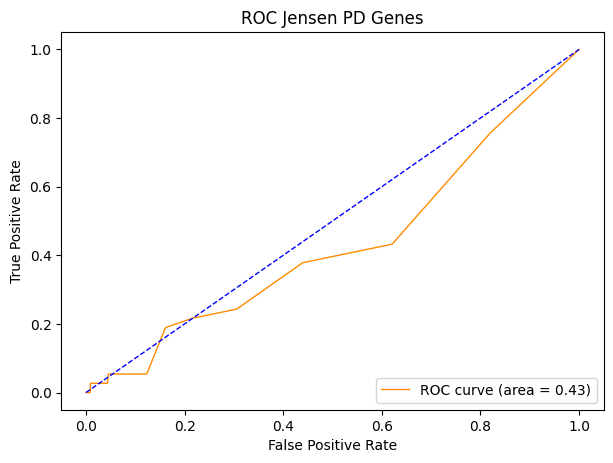

In [15]:
#running the ROCplotter function
ROCplotter(ROCjensen, jensenvaldf)

#Thought that the plot labels would be best outside of the function
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Jensen PD Genes')
plt.show()
